# Demo: SMILES → 3D Grid → VQGAN Reconstruction

## Getting Started

This notebook shows how to turn a molecular **SMILES** string into a 3D electron-density grid, compress and reconstruct it with a pre-trained **3D-Grid VQGAN** model, and visualize the before/after volumes.

---

## Setup Instructions

Before running any code, **upload** the following file into your notebook environment:

1. **`requirements.txt`**  
   Contains all Python dependencies needed for grid generation, PySCF, RDKit, VQGAN, and plotting.

---

## Installing Dependencies

Once `requirements.txt` is in place, execute:

In [ ]:
!pip install -r ../requirements.txt

### This will install:

- **NumPy**, **PyTorch**, **Matplotlib**
- **PySCF** (core quantum‐chemistry) + **pyberny**
- **pyscf‐semiempirical** (MINDO/PM3 stub)
- **RDKit** (SMILES parsing & conformer generation)
- **vq_gan_3d** (local VQGAN 3D package)
- **tqdm**, **heapq**, etc.


## Project Pipeline

```mermaid
flowchart TD
    A[SMILES String] --> B[3D Density Grid]
    B --> C[VQGAN Encoder]
    C --> D[VQGAN Decoder]
    D --> E[Reconstructed Grid]
    E --> F[3D Voxel Plot]


In [1]:
# Numerical computing
import numpy as np

# PyTorch
import torch
import torch.nn.functional as F

# Utilities to calculate grids from SMILES and visualization
from utils import get_grid_from_smiles, plot_voxel_grid, change_grid_size

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Generating 3D Electron-Density Grids from SMILES

Below are the high-level steps performed by `get_grid_from_smiles`:

1. **Parse & sanitize SMILES**  
   - Convert each SMILES string into an RDKit molecule.  
   - Canonicalize the SMILES for consistent naming.

2. **Embed 3D conformers (ETKDGv2)**  
   - Generate **50** candidate 3D conformations.  
   - Prune by RMSD to avoid duplicates.

3. **Optimize & rank conformers (MMFF)**  
   - Run MMFF force‐field optimization on all conformers.  
   - Compute their MMFF energies and select the **1** lowest‐energy structures.

4. **Quantum refinement & density grid (PySCF)**  
   For each of the top conformers:  
   - Convert RDKit geometry into a PySCF `Mole` object.  
   - (Optional) Optimize geometry with Berny solver.  
   - Perform SCF (RHF/DFT) to convergence.  
   - Calculate the electron‐density on a 3D grid with `cubegen.density`.  
   - Store the resulting ndarray (“rho”) together with SMILES and conformer ID.

5. **Return list of density grids**  
   - Output:  
     ```python
     [
       {"smiles": "CCO",  "name": "SMILES_0_1", "rho": ndarray(…128×128×128…)},
       {"smiles": "CCO",  "name": "SMILES_0_2", "rho": ndarray(…128×128×128…)},
       {"smiles": "CCO",  "name": "SMILES_0_3", "rho": ndarray(…128×128×128…)},
       …
     ]
     ```  
   - Ready for downstream VQGAN encoding/decoding and visualization.


In [2]:
smiles_list = ["CCCO"]
density_grids = get_grid_from_smiles(smiles_list)   


 molecule  CCCO

 ----> Conformer  1 


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -1.518677   0.020094  -0.069814    0.000000  0.000000  0.000000
   C  -0.087663  -0.329570  -0.436330    0.000000  0.000000  0.000000
   C   0.904273   0.199473   0.589643    0.000000  0.000000  0.000000
   O   2.225817  -0.165983   0.215515    0.000000  0.000000  0.000000
   H  -2.209757  -0.371249  -0.822891    0.000000  0.000000  0.000000
   H  -1.792079  -0.410910   0.898588    0.000000  0.000000  0.000000
   H  -1.655396   1.104781  -0.014318    0.000000  0.000000  0.000000
   H   0.019654  -1.417302  -0.524162    0.000000  0.000000  0.000000
   H   0.151904   0.077617  -1.425881    0.000000  0.000000  0.000000
   H   0.704900  -0.223834   1.579017    0.000000  0.000000  0.000000
   H   0.854551   1.290386   0.667088    0.000000  0.000000  0.000000
   H   2.402473   0.226497  -0.656455    0.000000  0.000000  0

## 1) Prepare Density Grids

In this step we take the raw 3D density arrays produced by PySCF and turn them into normalized PyTorch tensors that the VQGAN can ingest:

- **Convert** each NumPy array (`rho`) into a `torch.float32` tensor  
- **Apply** log‐normalization (`tensor = torch.log1p(rho)`) to compress dynamic range  
- **Ensure** a fixed resolution of **128×128×128**:
  - If the tensor is smaller or larger, **interpolate** trilinearly to 128³  
  - Remove the temporary batch/channel dimensions after interpolation  
- **Record** and log each tensor’s:
  - SMILES string and grid name  
  - Final shape (`(128,128,128)`)  
  - Minimum and maximum values  
- **Collect** all tensors into a list of dicts:
  ```python
  [
    {"name": "SMILES_0_1", "smiles": "CCO",  "tensor": <128³ tensor>},
    {"name": "SMILES_0_2", "smiles": "CCO",  "tensor": <128³ tensor>},
    …
  ]

## 2) Load the 3DGrid-VQGAN Model

Next, we load the pretrained 3DGrid-VQGAN checkpoint and prepare it for inference:

- **Import** the loader function from the local package:  
  ```python
  from vq_gan_3d import load_VQGAN
  ```

  - **Specify the checkpoint location:**  
  - `folder` — path to the directory containing `3DGrid-VQGAN_43.pt`  
  - `ckpt_filename` — the checkpoint filename  

- **Instantiate the model by calling:**  
  ```python
  vqgan = load_VQGAN(
      folder=folder,
      ckpt_filename=ckpt_file
  )

- **Move the model to the chosen device (GPU/CPU/MPS) and set it to evaluation mode:**  
```python
  vqgan = vqgan.to(device).eval()
  ```

- **Verify that the encoder and decoder submodules are accessible and ready for use:**  
```python
  _ = vqgan.encoder
  _ = vqgan.decoder
  ```

## 3) Encode → Decode Pipeline

Finally, we run each preprocessed grid through the VQGAN autoencoder and collect the results:

1. **Prepare input**  
   - Add batch & channel dims → shape `[1,1,128,128,128]`  
   - Move the tensor to the model’s device  

2. **Encode**  
   ```python
   indices = vqgan.encode(x)
  
3. **Decode**  
   ```python
   recon = vqgan.decode(indices)

4. **Store & report**  
    - Convert both `original` and `recon` back to NumPy
    - Compute MSE
    - Append a dict with SMILES, grid name, original array, reconstructed array, and MSE to `reconstructions`
    - Print a summary line, e.g.: 
    ```bash
   CCO → reconstruction done | MSE=0.000774



### Prepare Density Grids


In [3]:
# 1) Prepare density grids → list of ready-to-use tensors
processed_tensors = []
for item in density_grids:
    rho   = item["rho"]                   # raw NumPy array from cube generation
    smi   = item["smiles"]
    name  = item["name"]

    tensor = torch.from_numpy(rho).float() # convert grid to float32 tensor
    tensor = torch.log1p(tensor)           # apply log(ρ + 1) normalization

    # enforce consistent 128×128×128 input size for VQGAN
    if tensor.shape != torch.Size([128, 128, 128]):
        tensor = tensor.unsqueeze(0).unsqueeze(0)  # add batch & channel dims
        tensor = F.interpolate(
            tensor,
            size=(128, 128, 128),
            mode="trilinear",
            align_corners=False
        )[0, 0]                                    # remove extra dims after resizing
        print(f"[info] {smi} was interpolated to 128³")

    # store metadata alongside the processed tensor
    processed_tensors.append({
        "name":   name,
        "smiles": smi,
        "tensor": tensor
    })

    # log shape and min/max to verify normalization and sizing
    print(
        f"{smi}: shape={tuple(tensor.shape)}, "
        f"min={tensor.min():.4f}, max={tensor.max():.4f}"
    )

[info] CCCO was interpolated to 128³
CCCO: shape=(128, 128, 128), min=0.0000, max=3.8455


### Load the 3DGrid-VQGAN Model

In [4]:
# ------------------------------------------------------------------
# 2) Load 3DGrid-VQGAN model 
# ------------------------------------------------------------------
import sys
sys.path.insert(0, '../inference')
from vq_gan_3d import load_VQGAN
from pathlib import Path

ckpt_path   = Path("../data/checkpoints/pretrained/3DGrid-VQGAN_43.pt")
folder      = str(ckpt_path.parent)      
ckpt_file   = ckpt_path.name            

print("Loading 3DGrid-VQGAN checkpoint …")
vqgan = load_VQGAN(folder=folder, ckpt_filename=ckpt_file).to(device).eval()         
print("3DGrid-VQGAN ready.")

Loading 3DGrid-VQGAN checkpoint …
Random Seed: 0
n_times_upsample : [2 2 2]
max_us : 2


/u/vyukio/miniforge3/envs/fm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/vyukio/miniforge3/envs/fm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /dccstor/kcsys/vys/FM4M/models/3dgrid_vqgan/inference/vq_gan_3d/model/cache/vgg.pth
n_times_upsample : [2 2 2]
max_us : 2
loaded pretrained LPIPS loss from /dccstor/kcsys/vys/FM4M/models/3dgrid_vqgan/inference/vq_gan_3d/model/cache/vgg.pth
3DGrid-VQGAN ready.


### Encode → Decode Pipeline

In [5]:
# 3) Encode → Decode (inference with VQGAN)
reconstructions = []
for item in processed_tensors:
    smi  = item["smiles"]       # original SMILES string
    name = item["name"]         # unique grid name
    vol  = item["tensor"]       # preprocessed [128³] tensor

    # add batch & channel dims and move to the selected device
    x = vol.unsqueeze(0).unsqueeze(0).to(device)  # shape [1,1,128,128,128]

    with torch.no_grad():  # disable gradient computation for faster inference
        indices = vqgan.encode(x)   # map input volume to discrete latent codes
        recon   = vqgan.decode(indices)  # reconstruct volume from latent codes

    # convert reconstructed tensor and original tensor to NumPy arrays
    recon_np = recon.cpu().numpy()[0, 0]
    orig_np  = vol.cpu().numpy()

    # compute mean squared error between original and# 3) Encode → Decode (inference with VQGAN)
reconstructions = []
for item in processed_tensors:
    smi  = item["smiles"]       # original SMILES string
    name = item["name"]         # unique grid name
    vol  = item["tensor"]       # preprocessed [128³] tensor

    # add batch & channel dims and move to the selected device
    x = vol.unsqueeze(0).unsqueeze(0).to(device)  # shape [1,1,128,128,128]

    with torch.no_grad():  # disable gradient computation for faster inference
        indices = vqgan.encode(x)   # map input volume to discrete latent codes
        recon   = vqgan.decode(indices)  # reconstruct volume from latent codes

    # convert reconstructed tensor and original tensor to NumPy arrays
    recon_np = recon.cpu().numpy()[0, 0]
    orig_np  = vol.cpu().numpy()

    # compute mean squared error between original and reconstruction
    mse = np.mean((orig_np - recon_np) ** 2)
    print(f"{smi} → reconstruction done | MSE={mse:.6f}")

    # collect results for later visualization
    reconstructions.append({
        "smiles":       smi,
        "name":         name,
        "original":     orig_np,
        "reconstructed": recon_np
    })reconstruction
    mse = np.mean((orig_np - recon_np) ** 2)
    print(f"{smi} → reconstruction done | MSE={mse:.6f}")

    # collect results for later visualization
    reconstructions.append({
        "smiles":       smi,
        "name":         name,
        "original":     orig_np,
        "reconstructed": recon_np
    })

CCCO → reconstruction done | MSE=0.000774


### Voxel-Plot Helper Function

- **Purpose**: Render a 3D voxel grid inline


Plotting CCCO – Original


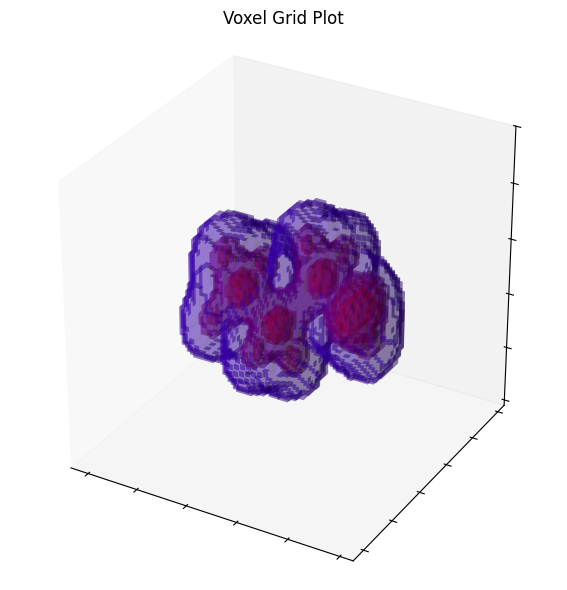


Plotting CCCO – Reconstructed


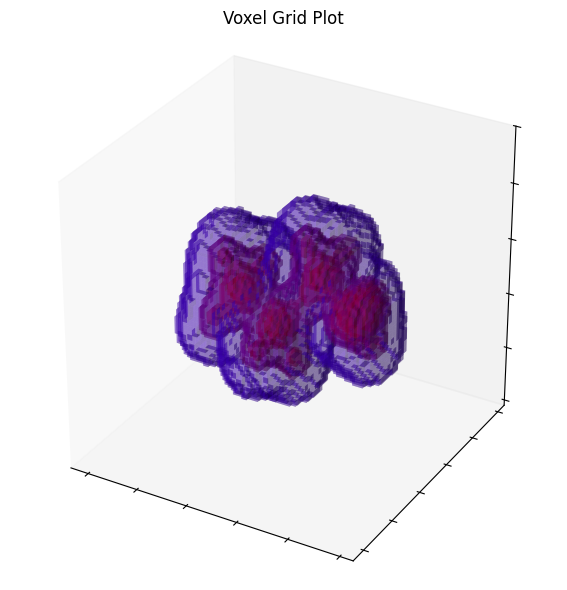

CPU times: user 42.5 s, sys: 2.71 s, total: 45.2 s
Wall time: 41.1 s


In [6]:
%%time
# the plot visualization of 3D grids takes a while, thus we reduced the grid size to speed up...
for rec in reconstructions:
    print(f"\nPlotting {rec['smiles']} – Original")
    plot_voxel_grid(
        change_grid_size(
            torch.from_numpy(rec["original"]).unsqueeze(0).unsqueeze(0), 
            size=(48, 48, 48)
        )
    )
    
    print(f"\nPlotting {rec['smiles']} – Reconstructed")
    plot_voxel_grid(
        change_grid_size(
            torch.from_numpy(rec["reconstructed"]).unsqueeze(0).unsqueeze(0), 
            size=(48, 48, 48)
        )
    )